# Рекомендация тарифов

Оператор мобильной связи «Мегалайн» выяснил: многие клиенты пользуются архивными тарифами. Компания хочет построить систему, способную проанализировать поведение клиентов и предложить пользователям новый тариф: «Смарт» или «Ультра».

В вашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы (из проекта курса «Статистический анализ данных»). Нужно построить модель для задачи классификации, которая выберет подходящий тариф. Предобработка данных не понадобится — мы её уже сделали.

Необходимо построить модель с максимально большим значением *accuracy*. Чтобы сдать проект успешно, нужно довести долю правильных ответов по крайней мере до 0.75. Необходимо проверить *accuracy* на тестовой выборке самостоятельно.

План работы: 

1.[Открытие файла с данными и изучение общей информации](#start)

2.[Разделение данных на выборки](#split)

3.[Исследование моделей](#exploration)

4.[Проверка моделей на тестовой выборке](#test)

5.[Проверка модели на адекватность](#test_1)

6.[Итоговые выводы](#conclusion)

<a id="start"></a>
## 1. Откройте и изучите файл

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
import warnings
warnings.simplefilter(action='ignore', category=Warning)
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('/datasets/users_behavior.csv')

In [3]:
df.head()

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
calls       3214 non-null float64
minutes     3214 non-null float64
messages    3214 non-null float64
mb_used     3214 non-null float64
is_ultra    3214 non-null int64
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


<div class="alert alert-info"> <b>с целью установления возможной мультиколлениарности рассматриваемых факторов, которая может стать причиной переробучения модели и увеличения сложности модели обучения, то есть факторов, которые имеют сильную связь друг с другом, посмотрим значения коэффициентов корреляции по рассматриваемым переменным. Будем считать, что вве переменных коллинеарны, когда они находятся между собой в линейной зависимости, то есть если коэффициент корреляции более 0,7.</b>

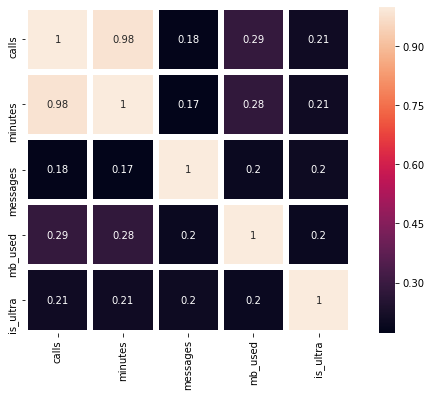

In [5]:
df_corr = df.corr()
f, ax = plt.subplots(figsize=(10, 6))
plt.xticks(rotation='90')
sns.heatmap(df_corr, square=True, linewidths=5, annot=True);

<div class="alert alert-info"> <b>мы наблюдаем сильную зависимость между общей длительностью звонков и количеством звонков в месяц, в частности коэффициент корелляции равен 0.98.Чтобы избавиться от мультиколлинарности, необходимо исключить из модели один из факторов, в нашем случае исключим такой фактор,  суммарная длительность звонков в месяц.<b/>

### Выводы

В ходе выполнения первого шага мы открыли интересующий файл с данными, сохранив его в датафрейме df, а также получили общую информацию об указанном датафрейме.
Таблица включает в себя 5 признаков и 3 214 объектов. Целевым признаком является is_ultra, остальные признаки будут служить для обучения модели, т.е. модель, которую мы попытаемся построить, будет предсказывать значение 1, если клиенту нужно предложить тариф "ультра", или 0, если тариф "Смарт". В этом и заключается задача бинарной классификации, т.к. наш целевой признак является категориальным.

<a id="split"></a>
## 2. Разбейте данные на выборки

Разделим исходные данные на обучающую, валидационную и тестовую выборки.

60% отводим под обучающую выборку, а 40 % на валидационную


In [6]:
df_train, df_valid = train_test_split(df, test_size=0.4, random_state=12345)

Далее, половину из оставшихся 40% отдаем на валидационную, другую половину – на тестовую. Таким образом, соотношение выборок в процентном выражении будет следующим: 60/20/20.


In [7]:
df_valid, df_test = train_test_split(df_valid, test_size=0.5, random_state=12345)

<div class="alert alert-info"> <b>посмотрим также на размеры выборок<b/>

In [8]:
df_train.shape

(1928, 5)

In [9]:
df_valid.shape

(643, 5)

In [10]:
df_test.shape

(643, 5)

как видим, выборки небольшие, поэтому существует большая вероятность переобучения модели

### Выводы

Мы разделили исходные данные на обучающую, валидационную и тестовую выборки.
Данные были разбиты в соотношении 60/20/20.
Обучение пройдет на данных df_train
Валидация модели на данных df_valid
Лучшая модель по валидации будет применена на данных df_test.

<a id="exploration"></a>
## 3. Исследуйте модели

На данном шаге мы исследуем качество разных моделей, меняя гиперпараметры.
Для решения задачи классификации рассмотрим следующие модели:

дерево решений / decision tree

случайный лес / random forest

логистическая регрессия / logistic regression

k - ближайших соседей/ k - nearеst neighbor

Подготовим фичи и целевые признаки обучающей и валидационных выборок

In [11]:
features_train = df_train.drop(['is_ultra', 'minutes'], axis=1)
target_train = df_train['is_ultra']

features_valid = df_valid.drop(['is_ultra', 'minutes'], axis=1)
target_valid = df_valid['is_ultra']

Начнем с дерева решений и посмотрим как изменение такого гиперпараметра, как глубина решающего дерева (max_depth), влияет на оценку точности модели. Глубину возьмем в диапазоне значений от 1 до 20 квлючительно.

### Дерево решений

In [12]:
best_depth = 0
best_result = 0
for depth in range(1, 21):
    model = DecisionTreeClassifier(max_depth=depth, random_state=12345)
    model.fit(features_train, target_train)
    predictions_valid = model.predict(features_valid)
    result = accuracy_score(target_valid, predictions_valid)
    print(f"depth = {depth}:\t{result}")
    if result > best_result:
        best_depth = depth
        best_result = result
print('Лучшая глубина дерева:', best_depth,'Лучшая точность:', best_result)

depth = 1:	0.7542768273716952
depth = 2:	0.7838258164852255
depth = 3:	0.7869362363919129
depth = 4:	0.7853810264385692
depth = 5:	0.7900466562986003
depth = 6:	0.7776049766718507
depth = 7:	0.776049766718507
depth = 8:	0.7729393468118196
depth = 9:	0.7822706065318819
depth = 10:	0.7729393468118196
depth = 11:	0.7667185069984448
depth = 12:	0.7573872472783826
depth = 13:	0.7527216174183515
depth = 14:	0.7511664074650077
depth = 15:	0.744945567651633
depth = 16:	0.7418351477449455
depth = 17:	0.744945567651633
depth = 18:	0.7480559875583204
depth = 19:	0.744945567651633
depth = 20:	0.7387247278382582
Лучшая глубина дерева: 5 Лучшая точность: 0.7900466562986003


Глядя на валидационную выборку мы можем сказать, что дерево решений имеет самую высокую оценку точности, когда в рассматриваемом диапазаоне гиперпараметр глубины равен 5.

In [13]:
%%time
best_tree_model = DecisionTreeClassifier(max_depth= 5, random_state=12345)
best_tree_model.fit(features_train, target_train)
predictions_valid = best_tree_model.predict(features_valid)
result = accuracy_score(target_valid, predictions_valid)
print('Глубина дерева:', 5,'Точность:',result)

Глубина дерева: 5 Точность: 0.7900466562986003
CPU times: user 10.5 ms, sys: 496 µs, total: 11 ms
Wall time: 8.58 ms


Далее настроим такоей гиперпараметр, как criterion, поменяем  значение gini, которое стоит по умлочанию, на entropy, глубину дерева оставим с наилучшим значнием.

In [14]:
%%time
model = DecisionTreeClassifier(max_depth=5, random_state=12345,criterion="entropy" )
model.fit(features_train, target_train)
predictions_valid = model.predict(features_valid)
result = accuracy_score(target_valid, predictions_valid)
print('Глубина дерева:', 5,'Точность:',result)

Глубина дерева: 5 Точность: 0.7869362363919129
CPU times: user 10.1 ms, sys: 401 µs, total: 10.5 ms
Wall time: 9.1 ms


как видим, на показатель точности модели это  повлияло, значение этого показателя снизилось.

Далее изменим значение гиперпараметра splitter с best на random.

In [15]:
%%time
model = DecisionTreeClassifier(max_depth=5, random_state=12345,splitter='random' )
model.fit(features_train, target_train)
predictions_valid = model.predict(features_valid)
result = accuracy_score(target_valid, predictions_valid)
print('Глубина дерева:', 5,'Точность:',result)

Глубина дерева: 5 Точность: 0.7776049766718507
CPU times: user 3.39 ms, sys: 3.96 ms, total: 7.35 ms
Wall time: 5.59 ms


как видим, качество (точность) модели существенно ухудшилось, поэтому значение best более предпочтительно

### Случайный лес 


В качестве гиперпараметра глубины дерева возьмем значение, которое в предыдущей модели мы определили как наилучшее из рассматриваемого диапазона, а именно 5.
Количество деревьев в нашем случайном лесу будет находиться в диапазоне от 10 до 100 с шагом 10.

In [16]:
best_estim = 0
best_result = 0
for estim in range(10, 101, 10):
    model = RandomForestClassifier(n_estimators=estim, max_depth=5, random_state=12345)
    model.fit(features_train, target_train)
    predictions_valid = model.predict(features_valid)
    result = accuracy_score(target_valid, predictions_valid)
    print(f"n_estimators = {estim}:\t{result}")    
    if result > best_result:
        best_estim = estim
        best_result = result
print('Лучший показатель количества деревьев:', best_estim,'Лучшая точность:', best_result)

n_estimators = 10:	0.7900466562986003
n_estimators = 20:	0.7838258164852255
n_estimators = 30:	0.7838258164852255
n_estimators = 40:	0.7807153965785381
n_estimators = 50:	0.7869362363919129
n_estimators = 60:	0.7869362363919129
n_estimators = 70:	0.7853810264385692
n_estimators = 80:	0.7853810264385692
n_estimators = 90:	0.7853810264385692
n_estimators = 100:	0.7838258164852255
Лучший показатель количества деревьев: 10 Лучшая точность: 0.7900466562986003


Как мы видим, модель случайного леса предсказывает тариф немного точнее, чем одно дерево, однако разница не так существенна, даже с учетом того, что количество деревьев составило 10, при этом скорость расчета, как мы понимаем, будет заметно медленнее.

In [17]:
%%time
best_forest_model = RandomForestClassifier(n_estimators=10, max_depth=5, random_state=12345)
best_forest_model.fit(features_train, target_train)
predictions_valid = best_forest_model.predict(features_valid)
result = accuracy_score(target_valid, predictions_valid)
print('Количество деревьев:', 10,'Точность',result)

Количество деревьев: 10 Точность 0.7900466562986003
CPU times: user 35.1 ms, sys: 0 ns, total: 35.1 ms
Wall time: 33.2 ms


Аналогичным образом настроим гиперпараметр criterion с gini на entropy.

In [18]:
%%time
model = RandomForestClassifier(n_estimators=10, max_depth=5, random_state=12345, criterion='entropy')
model.fit(features_train, target_train)
predictions_valid = model.predict(features_valid)
result = accuracy_score(target_valid, predictions_valid)
print('Количество деревьев:', 10,'Точность',result)

Количество деревьев: 10 Точность 0.7869362363919129
CPU times: user 34.2 ms, sys: 3.7 ms, total: 37.9 ms
Wall time: 60.4 ms


как видим, точность снизилась

Изменим значение гиперпараметра bootstrap с True на False.

In [19]:
%%time
model = RandomForestClassifier(n_estimators=10, max_depth=5, random_state=12345, bootstrap=False)
model.fit(features_train, target_train)
predictions_valid = model.predict(features_valid)
result = accuracy_score(target_valid, predictions_valid)
print('Количество деревьев:', 10,'Точность',result)

Количество деревьев: 10 Точность 0.7931570762052877
CPU times: user 36.7 ms, sys: 605 µs, total: 37.3 ms
Wall time: 35.3 ms


как видим, точность модели улудшилась, поэтому значение False гиперпараметра bootstrap более предпочительное

Также поэкспериментируем с гиперпараметром warm_start, в частности изменим с False на True

In [20]:
%%time
model = RandomForestClassifier(n_estimators=10, max_depth=5, random_state=12345, warm_start=True)
model.fit(features_train, target_train)
predictions_valid = model.predict(features_valid)
result = accuracy_score(target_valid, predictions_valid)
print('Количество деревьев:', 10,'Точность',result)

Количество деревьев: 10 Точность 0.7900466562986003
CPU times: user 36.8 ms, sys: 589 µs, total: 37.4 ms
Wall time: 34.7 ms


как видим, на показатель точности это не повлияло

таким образом, с учетом наших экспериментов с гиперпараметрами, сохраним лучшую модель случайного леса

In [21]:
%%time
best_forest_model = RandomForestClassifier(n_estimators=10, max_depth=5, random_state=12345, bootstrap=False)
best_forest_model.fit(features_train, target_train)
predictions_valid = best_forest_model.predict(features_valid)
result = accuracy_score(target_valid, predictions_valid)
print('Количество деревьев:', 10,'Точность',result)

Количество деревьев: 10 Точность 0.7931570762052877
CPU times: user 32.7 ms, sys: 3.45 ms, total: 36.1 ms
Wall time: 34.1 ms


### Логистическая регрессия

Переходим к логистической регрессии. Посмотрим, как влияет изменение гиперпараметра max_iter (количество итераций) на точность модели, количество итераций возьмем в диапазоне значений от 1 до 100.

In [22]:
best_max_iter = 0
best_result = 0

for max_iter in range(1,101):
    model = LogisticRegression(random_state=12345, max_iter=max_iter)
    model.fit(features_train, target_train)
    valid_predictions = model.predict(features_valid)
    result = accuracy_score(target_valid, valid_predictions)
    print('Количество итерраций:', max_iter,'Точность:',result)
    if result > best_result:
        best_max_iter = max_iter
        best_result = result

print('Лучший показатель количества итерраций:', best_max_iter,'Лучшая точность:', best_result)

Количество итерраций: 1 Точность: 0.7060653188180405
Количество итерраций: 2 Точность: 0.7060653188180405
Количество итерраций: 3 Точность: 0.7060653188180405
Количество итерраций: 4 Точность: 0.7060653188180405
Количество итерраций: 5 Точность: 0.7060653188180405
Количество итерраций: 6 Точность: 0.7060653188180405
Количество итерраций: 7 Точность: 0.7076205287713841
Количество итерраций: 8 Точность: 0.7091757387247278
Количество итерраций: 9 Точность: 0.7091757387247278
Количество итерраций: 10 Точность: 0.7076205287713841
Количество итерраций: 11 Точность: 0.7060653188180405
Количество итерраций: 12 Точность: 0.7091757387247278
Количество итерраций: 13 Точность: 0.7091757387247278
Количество итерраций: 14 Точность: 0.7091757387247278
Количество итерраций: 15 Точность: 0.7091757387247278
Количество итерраций: 16 Точность: 0.713841368584759
Количество итерраций: 17 Точность: 0.7153965785381027
Количество итерраций: 18 Точность: 0.7511664074650077
Количество итерраций: 19 Точность: 0.7

как видим, количество итераций в рассматриваемом диапазоне значений, имальное количество итераций равно 18, при этом с увеличением данного показателя показатель точности не изменяется.

In [23]:
%%time
best_log_model = LogisticRegression(random_state=12345, max_iter=18)
best_log_model.fit(features_train, target_train)
valid_predictions = best_log_model.predict(features_valid)
result = accuracy_score(target_valid, valid_predictions)
print('Количество итерраций:', 18,'Точность:',result)

Количество итерраций: 18 Точность: 0.7511664074650077
CPU times: user 12.2 ms, sys: 3.52 ms, total: 15.7 ms
Wall time: 13.6 ms


Поэкспериментируем со значениями другого гиперпараметра,а именно solver.

In [24]:

best_solver = ''
best_result = 0
solvers = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
for solve in solvers:
    model = LogisticRegression(random_state=12345, max_iter=18, solver=solve)
    model.fit(features_train, target_train)
    valid_predictions = model.predict(features_valid)
    result = accuracy_score(target_valid, valid_predictions)
    print('Solver:', solve,'Точность:',result)
    if result > best_result:
        best_solver= solve
        best_result = result
print('Лучшее значение solver:', best_solver,'Лучшая точность:', best_result)

Solver: newton-cg Точность: 0.7402799377916018
Solver: lbfgs Точность: 0.7076205287713841
Solver: liblinear Точность: 0.7511664074650077
Solver: sag Точность: 0.7060653188180405
Solver: saga Точность: 0.7060653188180405
Лучшее значение solver: liblinear Лучшая точность: 0.7511664074650077


как видим, лучший алгоритм задачи оптимизации - liblinear.

изменим значение гиперпараметра fit_intercept с True на False

In [25]:
%%time
model = LogisticRegression(random_state=12345, max_iter=18, solver = 'liblinear', fit_intercept=False)
model.fit(features_train, target_train)
valid_predictions = model.predict(features_valid)
result = accuracy_score(target_valid, valid_predictions)
print('Количество итерраций:', 18,'Точность:',result)

Количество итерраций: 18 Точность: 0.7076205287713841
CPU times: user 8.17 ms, sys: 4.09 ms, total: 12.3 ms
Wall time: 9.84 ms


как видим, точность ухудшилась, поэтому лцучше оставить значение fit_intercept по умолчанию.

### Метод K - ближайших соседей

посмотрим на качество данной модели, изменяя параметр количества "соседей" в диапазоне значени от 1 до 10.

In [26]:
best_n_neighbors = 0
best_result = 0
for k in range(1,11):
    model = KNeighborsClassifier(n_neighbors=k)
    model.fit(features_train, target_train)
    predictions_valid = model.predict(features_valid)
    result = accuracy_score(target_valid, predictions_valid)
    print(f"n_neighbors = {k}:\t{result}")    
    if result > best_result:
        best_n_neighbors = k
        best_result = result
print('Лучший показатель количества соседей:', best_n_neighbors,'Лучшая точность:', best_result)

n_neighbors = 1:	0.6889580093312597
n_neighbors = 2:	0.7511664074650077
n_neighbors = 3:	0.744945567651633
n_neighbors = 4:	0.7527216174183515
n_neighbors = 5:	0.7371695178849145
n_neighbors = 6:	0.7402799377916018
n_neighbors = 7:	0.7293934681181959
n_neighbors = 8:	0.744945567651633
n_neighbors = 9:	0.7402799377916018
n_neighbors = 10:	0.7511664074650077
Лучший показатель количества соседей: 4 Лучшая точность: 0.7527216174183515


Как мы видим, модель к-ближайших соседей предсказывает тариф немного точнее, чем логистическая регрессия, однако менее точно, чем деревья решений

In [27]:
%%time
best_neighbor_model = KNeighborsClassifier(n_neighbors=4)
best_neighbor_model.fit(features_train, target_train)
predictions_valid = best_neighbor_model.predict(features_valid)
result = accuracy_score(target_valid, predictions_valid)
print('Количество соседей:', 4,'Точность:',result)

Количество соседей: 4 Точность: 0.7527216174183515
CPU times: user 32.7 ms, sys: 21.2 ms, total: 53.8 ms
Wall time: 42.7 ms


попробуем поизменять значение такого гиперпараметра, как algorithm

In [28]:

best_algorithm = ''
best_result = 0

for algorithm in {'auto', 'ball_tree', 'kd_tree', 'brute'}:
    model = KNeighborsClassifier(n_neighbors=4)
    model.fit(features_train, target_train)
    valid_predictions = model.predict(features_valid)
    result = accuracy_score(target_valid, valid_predictions)
    print('Algorithm:', algorithm,'Точность:',result)
    if result > best_result:
        best_algorithm= algorithm
        best_result = result

print('Лучший algorithm:', best_algorithm,'Лучшая точность:', best_result)

Algorithm: ball_tree Точность: 0.7527216174183515
Algorithm: auto Точность: 0.7527216174183515
Algorithm: brute Точность: 0.7527216174183515
Algorithm: kd_tree Точность: 0.7527216174183515
Лучший algorithm: ball_tree Лучшая точность: 0.7527216174183515


как видим, изменение данного гиперпараметра не влияет на точность модели.

попробуем также изменить гиперпараметр weights  c uniform на distance

In [29]:
%%time
model = KNeighborsClassifier(n_neighbors=4, weights = 'distance')
model.fit(features_train, target_train)
predictions_valid = model.predict(features_valid)
result = accuracy_score(target_valid, predictions_valid)
print('Количество соседей:', 4,'Точность:',result)

Количество соседей: 4 Точность: 0.7402799377916018
CPU times: user 10.3 ms, sys: 257 µs, total: 10.6 ms
Wall time: 8.56 ms


как видим, после внесения данных изменений качество модели ухудшилось.

###  Выводы

В ходе исследования, мы оценивали качество разных моделей, меняя их гиперпараметры.
Для решения задачи классификации рассмотрены следующие модели:

дерево решений / decision tree

случайный лес / random forest

логистическая регрессия / logistic regression

k - ближайших соседей/ k - nearеst neighbor

В итоге по указанным моделям мы получили следующие лучшие результаты:

Точность модели решающего дерева при глубине 5 равна 0.79004. 

Точность модели случайного леса при количестве деревьев 10 равна 0.79315. 

Точность модели логистической регресии при количестве итераций, равном 18, равна 0.75116. 

Точност модели к-ближайших соседей при количестве сосдедей, равном 4, равна 0.75272.
Таким образом, наилучший результат показала модель случайного леса.

<a id="test"></a>
## 4. Проверьте модель на тестовой выборке

В результате наших экспериментов на валидационной выборке мы выяснили, что самую высокую оценку правильности дает случайный лес с глубиной равной 5 и количеством деревьев равным 10.


Проверим,как поведет себя данная модель на тестовой выборке.

In [30]:
features_test = df_test.drop(['is_ultra', 'minutes'], axis=1)
target_test = df_test['is_ultra']

model = RandomForestClassifier(n_estimators=10, max_depth=5, random_state=12345, bootstrap=False)
model.fit(features_train, target_train)
predictions_test = model.predict(features_test)
accuracy = accuracy_score(target_test, predictions_test)
print('Точность модели случаный лест на тестовой выборке',accuracy)


Точность модели случаный лест на тестовой выборке 0.7853810264385692


In [31]:
model = DecisionTreeClassifier(max_depth= 5, random_state=12345)
model.fit(features_train, target_train)
predictions_test = model.predict(features_test)
accuracy = accuracy_score(target_test, predictions_test)
print('Точность модели дерево решений на тестовой выборке',accuracy)

Точность модели дерево решений на тестовой выборке 0.7838258164852255


In [32]:
model = LogisticRegression(random_state=12345, max_iter=18)
model.fit(features_train, target_train)
predictions_test = model.predict(features_test)
accuracy = accuracy_score(target_test, predictions_test)
print('Точность модели логистической регрессии на тестовой выборке',accuracy)

Точность модели логистической регрессии на тестовой выборке 0.7433903576982893


In [33]:
model = KNeighborsClassifier(n_neighbors=4)
model.fit(features_train, target_train)
predictions_test = model.predict(features_test)
accuracy = accuracy_score(target_test, predictions_test)
print('Точность модели к - ближайших соседей на тестовой выборке',accuracy)

Точность модели к - ближайших соседей на тестовой выборке 0.71850699844479


### Выводы

На тестовой выборке модель случайного леса показывает значение accuracy, приближенное к тренировочной выборке, но все же ее точность ниже, при этом значение точности на тестовой выборке модели решающее дерево немного ниже, чем у случайного леса. Меньшие значения точности на тестовых выборках мы наблюдаем и по моделям логистической регрессии и к-ближайших соседей, в последнем случае разница особенно велика. Таким образом, в данном случае мы наблюдаем проблему переообучения, но значения, за исключением модели к-ближайших соседей, отличаются не существенно, поэтому можем считать, что нам удалось построить модель для задачи бинарной классификации, которая выберет подходящий тариф.

Таким образом, с учетом того, что выборка не будет большой, в данном случае можно рекомендовать к использованию модель случайного леса.

<a id="test_1"></a>
## 5. (бонус) Проверьте модели на адекватность

Любая модель дает приближенное описание реального процесса функционирования объекта или системы. Поэтому необходима  процедура доказательства адекватности построенной модели. От решения задачи оценки адекватности зависит степень доверия к результатам.
Оценка адекватности модели заключается в проверке степени совпадения модели и реальной системы.В данном случае мы хотим, чтобы выпущенная в "жизнь" модель не была подвержена переобучению или недообучению, то есть работала хорошо на реальных данных, которые она не видела в процессе обучения.



Так, например, оценить адекватность (вменяемость) модели можно, используя несколько метрик:

accuracy - точность совпадения прогнозов с правильными ответами.

precision - доля объектов, названных классификатором положительными и при этом действительно являющимися положительными.

recall - показывает, какую долю объектов положительного класса из всех объектов положительного класса нашел алгоритм.

оценим адекватность модели случайного леса, которую мы признали наилучшей для решения поставленной задачи.

In [34]:
test_predictions = best_forest_model.predict(features_test)
accuracy = accuracy_score(target_test, test_predictions)
precision = precision_score(target_test, test_predictions)
recall = recall_score(target_test, test_predictions)
print('Accuracy =', accuracy, 'Precision =', precision, 'Recall =', recall)

Accuracy = 0.7853810264385692 Precision = 0.7480916030534351 Recall = 0.4827586206896552


Существует несколько различных способов объединить precision и recall в агрегированный критерий качества. Так, для оценки адеватности используется F-мера - среднее гармоническое между precision и recall. Если хотя бы один из параметров близок к нулю, то и F-мера стремится к 0. Если оба стремятся к 1, то F-мера тоже стремится к 1.

In [35]:
f_score = f1_score(target_test, test_predictions)
print('F-мера =', f_score)

F-мера = 0.5868263473053893


качество модели можно считать средним, при этом вцелом модель можно считать адеватной для решения поставленной задачи.

### Выводы

На 5 шаге мы оценивали адекватность модели случайный лес, которую мы выбрали наилучшей для решения поставленной задачи. 

Мы предположили, что адекватность модели оценивается по нескольким параметрам, в частности для модели классификации это такие метрики, как accuracy, precision и recall. Качество модели лучше всего отражают precision и recall, при этом данные метрики складываются в F-мера как единую оценку качества модели.

По результатам проведенных расчетов мы установили, рассматриваемая модель случайного леса получилась среднего качества, при этом для нашей задачи можно считать ее адеквантой.

<a id="conclusion"></a>
## Итоговые выводы

В ходе выполнения данной работы сделано нижеследующее.

1. В ходе выполнения первого шага мы открыли интересующий файл с данными, сохранив его в датафрейме df, а также получили общую информацию об указанном датафрейме.
Таблица включает в себя 5 признаков и 3 214 объектов. Целевым признаком является is_ultra, остальные признаки служат для обучения модели, т.е. модель, которую мы попытались построить, должно предсказывать значение 1, если клиенту нужно предложить тариф "ультра", или 0, если тариф "Смарт". В этом и заключается задача бинарной классификации, т.к. наш целевой признак является категориальным.

2. В процессе выполнения 2 шага мы разделили исходные данные на обучающую, валидационную и тестовую выборки.
Данные были разбиты в соотношении 60/20/20.

Обозначено, что:

* Обучение пройдет на данных df_train

* Валидация модели на данных df_valid

* Лучшая модель по валидации будет применена на данных df_test.


3. В ходе выполнения 3 шага, а именно исследования, мы оценивали качество разных моделей, меняя их гиперпараметры. Для решения задачи классификации рассмотрены следующие модели:

дерево решений / decision tree

случайный лес / random forest

логистическая регрессия / logistic regression

k - ближайших соседей/ k - nearest neighbor

В итоге, по результам исследования данных моделей, путем изменения их гиперпараметров, мы получили следующие лучшие результаты:

Точность модели решающего дерева при глубине 5 равна 0.79004. 

Точность модели случайного леса при количестве деревьев 10 равна 0.79315. 

Точность модели логистической регресии при количестве итераций, равном 18, равна 0.75116. 

Точност модели к-ближайших соседей при количестве сосдедей, равном 4, равна 0.75272.
Таким образом, наилучший результат показала модель случайного леса.

4. В ходе выполнения 4 шага мы проверяли, как поведут себя наши модели на тестовой выборке.
   На тестовой выборке модель случайного леса показала  значение accuracy, приближенное к тренировочной выборке, но все же ее точность ниже, при этом значение точности на тестовой выборке модели решающее дерево немного ниже, чем у случайного леса. Меньшие значения точности на тестовых выборках мы наблюдаем и по моделям логистической регрессии и к-ближайших соседей, в последнем случае разница особенно велика. Таким образом, в данном случае мы наблюдаем проблему переообучения, но значения, за исключением модели к-ближайших соседей, отличаются не существенно, поэтому можем считать, что нам удалось построить модель для задачи бинарной классификации, которая выберет подходящий тариф.

Таким образом, с учетом того, что выборка не будет большой, в данном случае можно рекомендовать к использованию модель случайно

5. На 5 шаге мы оценивали адекватность модели случайный лес, которую мы выбрали наилучшей для решения поставленной задачи. 

Мы предположили, что адекватность модели оценивается по нескольким параметрам, в частности для модели классификации это такие метрики, как accuracy, precision и recall. Качество модели лучше всего отражают precision и recall, при этом данные метрики складываются в F-мера как единую оценку качества модели.

По результатам проведенных расчетов мы установили, рассматриваемая модель случайного леса получилась среднего качества, при этом для нашей задачи можно считать ее адеквантой.